In [1]:
import os
import csv
import pickle
import glob
import cv2
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
labels_dir = os.getcwd()+'\labels'
data_dir = os.getcwd()+'\Data'
labels_list = os.listdir(labels_dir)
data_list = os.listdir(data_dir)

In [3]:
txt = []
for index in range(0, len(labels_list)): #start from new dataset
    label = labels_list[index]
    txt.append(os.path.join(labels_dir, label))

In [4]:
dt = []
for index in range(0, len(data_list)): #start from new dataset
    d = data_list[index]
    dt.append(os.path.join(data_dir, d))

In [6]:
def extract_label(txt):
    clean_vars = []
    with open(txt, 'r') as csvfile:
    # with open(r'C:\Users\phili\techlabs\eth_sms\labels\SMS_064_Körperlage.txt', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar=",")
        for row in reader:
            # clean up your file here and append it to the list
            clean_vars.append([char for char in row if char])

    my_string = ' '.join(map(str,clean_vars[1]))
    start_date = my_string.split(":",1)[1]
    start = start_date[0:11] #get only the date

    list = clean_vars[6:] #get the labels
    df = pd.DataFrame(list, columns=['time','Position'])
    # start = pd.to_datetime(start, format='%d%m%Y')
    df.time = df.time.str.replace(',','.')
    df.time = df.time.str.lstrip()
    # df.time = df.time.str.replace(" ", "", n = 1)
    df.time = df.time.apply(lambda x: ' '.join((start, x))) # add date
    # df.time= pd.to_datetime(df.time)
    # morning_hour = df.iloc[-1]['time'].hour '%m/%d/%Y %H:%M:%S.%f'
    df.time = pd.to_datetime(df['time'], format=' %d.%m.%Y %H:%M:%S.%f')
    df.time = pd.to_datetime(df.time).apply(lambda x: x + pd.DateOffset(days=1) if x.hour <= 10 else x) # corect the date after 0 o'clock
    # df.time = pd.to_datetime(df.time,format='%Y/%m/%d %H:%M:%S.%f')
    # df_end = df[df['Position']!=' A']
    df_end = df
    df_end = df_end.reset_index().drop(columns= ['index'])
    df_end['end'] = df_end['time'].shift(-1) # get the duration
    df_end['end'] = np.where(df_end['end'].isnull(), df_end['time'], df_end['end'])
    return df_end


In [7]:
def extract_label_old(txt):
    clean_vars = []
    with open(txt, 'r') as csvfile:
    # with open(r'C:\Users\phili\techlabs\eth_sms\labels\SMS_064_Körperlage.txt', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar=",")
        for row in reader:
            # clean up your file here and append it to the list
            clean_vars.append([char for char in row if char])
    info = clean_vars[483:]
    df = pd.DataFrame(info)
    df[0] = df[0].str.replace('\t',',')
    dfnew = df[0].str.split(',', expand=True)
    df_end = dfnew[dfnew[3].str.contains('POSITION')].reset_index().drop(columns=['index',0,1,4,5]).rename({2: 'time', 3: 'Position'}, axis=1)
    df_end.time = pd.to_datetime(df_end['time'], format='%Y.%m.%dT%H:%M:%S.%f')
    df_end['end'] = df_end['time'].shift(-1) # get the duration
    df_end['end'] = np.where(df_end['end'].isnull(), df_end['time'], df_end['end'])
    return df_end



In [8]:
def get_data(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['time'] = df_new['time'] + pd.Timedelta(hours=1)
    df_new['end'] = df_new['end'] + pd.Timedelta(hours=1)
    df_new['label'] = 0
    return df_new

In [9]:
def get_data_old(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['time'] = df_new['time'] 
    df_new['end'] = df_new['end'] 
    df_new['label'] = 0
    return df_new

In [10]:
def get_label(txt,dt):
    if txt[-10:-4]=='Events':
        df_end = extract_label_old(txt)
        df_new = get_data_old(dt)
    else:
        df_end = extract_label(txt)
        df_new = get_data(dt)
    # df_new = get_data(dt)
    for i in range(len(df_new['end'])):
        for j in range(len(df_end['time'])):

            if (df_new['time'][i] >= df_end['time'][j]) & (df_new['time'][i] <= df_end['end'][j]):
                df_new['label'][i] = df_end['Position'][j]
                break
            else:
                continue

    

    return df_new, df_end

In [11]:
df_merged, df_end = get_label(txt[0],dt[0])

In [134]:
# Bring number of sample
num_img = 200
counts_col = df_merged.groupby("label")["label"].transform(len)
mask = (counts_col > int(num_img)) 
df_merged = df_merged[mask]
sample = df_merged.groupby('label').sample(n=int(num_img),random_state=2).reset_index().drop(columns=['index'])

In [135]:
sample

,time,pressure,end,label
0,2021-08-08 21:42:05.787,"[[275.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:42:06.489,0
1,2021-08-08 21:15:42.964,"[[263.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:15:43.665,0
2,2021-08-08 21:10:59.477,"[[256.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:10:59.978,0
3,2021-08-08 21:44:36.560,"[[266.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:44:37.362,0
4,2021-08-08 21:07:43.513,"[[263.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:07:44.014,0
...,...,...,...,...
595,2021-08-08 22:39:56.396,"[[276.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 22:39:57.097,POSITION-UNKNOWN
596,2021-08-08 22:28:10.787,"[[279.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16...",2021-08-08 22:28:11.489,POSITION-UNKNOWN
597,2021-08-08 22:40:00.706,"[[276.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 22:40:01.508,POSITION-UNKNOWN
598,2021-08-08 22:40:24.062,"[[279.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15...",2021-08-08 22:40:24.764,POSITION-UNKNOWN


In [137]:
sample.label.unique()

array([0, 'POSITION-SUPINE', 'POSITION-UNKNOWN'], dtype=object)

In [143]:
sample.label = pd.np.where(sample.label == 0,' Zeros', sample.label)

In [146]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [148]:
sample

,time,pressure,end,label
0,2021-08-08 21:42:05.787,"[[275.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:42:06.489,Zeros
1,2021-08-08 21:15:42.964,"[[263.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:15:43.665,Zeros
2,2021-08-08 21:10:59.477,"[[256.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:10:59.978,Zeros
3,2021-08-08 21:44:36.560,"[[266.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:44:37.362,Zeros
4,2021-08-08 21:07:43.513,"[[263.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 21:07:44.014,Zeros
...,...,...,...,...
595,2021-08-08 22:39:56.396,"[[276.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 22:39:57.097,POSITION-UNKNOWN
596,2021-08-08 22:28:10.787,"[[279.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16...",2021-08-08 22:28:11.489,POSITION-UNKNOWN
597,2021-08-08 22:40:00.706,"[[276.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14...",2021-08-08 22:40:01.508,POSITION-UNKNOWN
598,2021-08-08 22:40:24.062,"[[279.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15...",2021-08-08 22:40:24.764,POSITION-UNKNOWN


In [149]:
sample.label = sample.label.astype('category')

In [150]:
sample.label = sample.label.cat.codes

In [92]:
sample.pressure[0].shape

(48, 22)

CNN

In [80]:
from tensorflow import keras
import tensorflow as tf
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from keras import layers

In [107]:
def CAE(input_shape=(48, 48, 1), filters=[32, 64, 128, 10]):
    model = keras.Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(layers.Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))

    model.add(layers.Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))

    model.add(layers.Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=filters[3], name='embedding'))
    model.add(layers.Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))

    model.add(layers.Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(layers.Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))

    model.add(layers.Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))

    model.add(layers.Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    model.summary()
    return model

In [108]:
model = CAE()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 12, 12, 64)        51264     
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 embedding (Dense)           (None, 10)                46090     
                                                                 
 dense_3 (Dense)             (None, 4608)              50688     
                                                                 
 reshape_3 (Reshape)         (None, 6, 6, 128)        

In [110]:
collect = []
for i in range(len(sample.pressure)):

    img = sample.pressure[i]
    img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
    reshaped_img = img.reshape(48, 48, 1)
    collect.append(reshaped_img)

In [111]:
collect = np.array(collect)

In [112]:
collect.shape

(600, 48, 48, 1)

In [113]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.mean_squared_error
model.compile(optimizer=optimizer, loss= loss, metrics=["accuracy"])

In [114]:
model.fit(collect , collect, epochs=20)

Epoch 1/20
19/19 [==============================] - 1s 37ms/step - loss: 11305.6367 - accuracy: 0.0449
Epoch 2/20
19/19 [==============================] - 1s 37ms/step - loss: 4104.9028 - accuracy: 0.0095
Epoch 3/20
19/19 [==============================] - 1s 39ms/step - loss: 2396.3464 - accuracy: 0.0375
Epoch 4/20
19/19 [==============================] - 1s 37ms/step - loss: 1886.6058 - accuracy: 0.0818
Epoch 5/20
19/19 [==============================] - 1s 37ms/step - loss: 1763.0404 - accuracy: 0.1292
Epoch 6/20
19/19 [==============================] - 1s 37ms/step - loss: 1714.6389 - accuracy: 0.1585
Epoch 7/20
19/19 [==============================] - 1s 37ms/step - loss: 1662.5537 - accuracy: 0.1681
Epoch 8/20
19/19 [==============================] - 1s 37ms/step - loss: 1427.3292 - accuracy: 0.1899
Epoch 9/20
19/19 [==============================] - 1s 38ms/step - loss: 1052.0986 - accuracy: 0.2278
Epoch 10/20
19/19 [==============================] - 1s 37ms/step - loss: 892.547

In [115]:
mm = keras.Model(inputs=model.input, outputs=model.output)
mm.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_input (InputLayer)    [(None, 48, 48, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 12, 12, 64)        51264     
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 embedding (Dense)           (None, 10)                46090     
                                                                 
 dense_3 (Dense)             (None, 4608)              5068

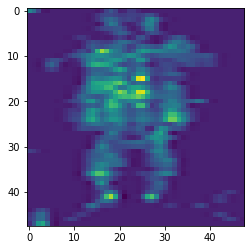

In [117]:
plt.imshow(collect[3].reshape((48,48)))

In [118]:
model.save("Autoencoder_patient.h5")

In [119]:
embdedded_model = keras.Model(inputs=model.input, outputs=model.get_layer(name="embedding").output)
embdedded_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_input (InputLayer)    [(None, 48, 48, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 12, 12, 64)        51264     
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 embedding (Dense)           (None, 10)                46090     
                                                                 
Total params: 172,042
Trainable params: 172,042
Non-trainab

In [120]:
features = embdedded_model.predict(collect)

In [121]:
features.shape

(600, 10)

In [122]:
from sklearn.manifold import TSNE

In [123]:
tsne = TSNE(n_components=2)
digit_features_tsne = tsne.fit_transform(features)

In [151]:
y = sample.label

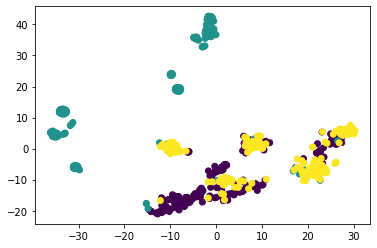

In [153]:
plt.scatter(digit_features_tsne[:,0], digit_features_tsne[:,1], c=y)

In [154]:
import pandas as pd

tsne_df = tsne_df = pd.DataFrame(
    np.column_stack((digit_features_tsne, y)),
    columns = ['X', 'y', 'targets']
)

c:\Users\phili\techlabs\ai_venv\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


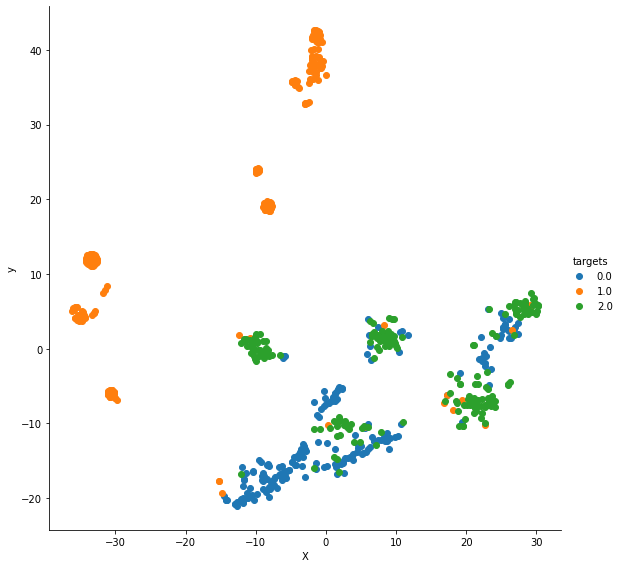

In [155]:
import seaborn as sns
grid = sns.FacetGrid(tsne_df, hue='targets', size=8)
grid.map(plt.scatter, 'X', 'y').add_legend()

Transfer Learning

In [16]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
import tensorflow as tf
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.layers import Concatenate
import cv2

In [17]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [19]:
data = []
for i in range(len(sample.pressure)):

    img = sample.pressure[i]
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    reshaped_img = img.reshape(224, 224, 1)
    img_conc = Concatenate()([reshaped_img, reshaped_img, reshaped_img])
    img_conc = tf.reshape(img_conc,(1,224,224,3))
    # prepare image for model
    imgx = preprocess_input(img_conc)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    data.append(features)


In [70]:
test = np.array(data)

In [72]:
test = test.reshape(-1,len(sample))

In [61]:
len(data)

600

In [62]:
len(y)

600

In [22]:
X_train = np.array(data)
X = X_train.reshape(-1,len(sample))#We will only be using X for clustering. No need of y.

In [75]:
test.shape

(4096, 600)

In [65]:
X

array([[0.       , 5.1214557, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.04699  , ..., 0.       , 5.888844 ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.9012717],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 2.8837621, ..., 0.       , 1.8030102,
        0.       ]], dtype=float32)

In [24]:
from sklearn.manifold import TSNE

In [73]:
tsne = TSNE(n_components=2)
# digit_features_tsne = tsne.fit_transform(X)
digit_features_tsne = tsne.fit_transform(test)

In [39]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [51]:
sample.label = sample.label.astype(str)
sample.label = le.fit_transform(sample.label.values)

In [57]:
y = sample.label

In [58]:
y = np.array(y)

In [59]:
len(y)

600

In [54]:
y = y.reshape(-1,1)

In [60]:
len(X)

4096

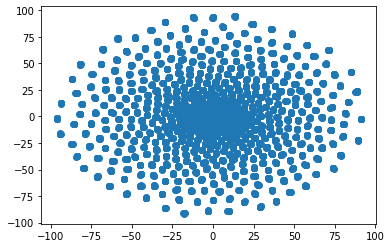

In [74]:
plt.scatter(digit_features_tsne[:,0], digit_features_tsne[:,1])